# Preprocessing, Feature Engineering, and Non-Linear Classifiers
In this lab we are going to train a classifier to predict which passengers survived the Titanic based on demographic information and travel details. 

This is a great dataset for learning the importance of feature engineering. Providing the model with informative features is critical to achieving high performance. 

First, we will try fitting some classifiers without doing any data engineering other than imputation and encoding categorical features. 

In the second half of the lab, you will engineer new features and hopefully gain an intuition on how we devise features that are informative to the ML task. 

We will also experiment with several models that you have been reviewing in class: LogisticRegression, RandomForest, XGBoost, SVC, NaiveBayes, and K-NN.

### Import the libraries
You may need to install `xgboost` if you do not already have it

In [5]:
import pathlib
from typing import Tuple
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler, PowerTransformer, OneHotEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve
from xgboost import XGBClassifier

In [6]:
### Constants
_DATA_PATH = pathlib.Path("../data") / "lab-5"  # Note functionality of division operator (__truediv__) on Path objects
_DATA_PATH

PosixPath('../data/lab-5')

### Data Ingestion

Either download the dataset from Kaggle ([link](https://www.kaggle.com/competitions/titanic/data?select=train.csv)) and use the train.csv or import it with the following line:

In [7]:
# # Optional, import data with kaggle API
# try: 
#     import kaggle
#     kaggle.api.authenticate()
#     kaggle.api.competition_download_files('titanic', path=_DATA_PATH)
# except ModuleNotFoundError as e:
#     print("Kaggle not installed, use 'pip install kaggle' or " 
#           "'conda install -c conda-forge kaggle' and restart Jupyter kernel. "
#           "Otherwise, download data and place in folder above manually"
#     )
#     print(e.message())
# except Exception as e:
#     raise e
    

In [8]:
import zipfile
fname = "titanic.zip"
with zipfile.ZipFile(_DATA_PATH / fname, "r") as handle:
    handle.extractall(_DATA_PATH)

In [9]:
# Load the Titanic train and test datasets
train_df = pd.read_csv(_DATA_PATH/"train.csv", index_col="PassengerId")
test_df = pd.read_csv(_DATA_PATH/"test.csv", index_col="PassengerId")

In [10]:
# Explore the first few rows of the dataset
train_df.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


### What do these features mean?

| Variable  | Definition                  | Key                                                |
|-----------|-----------------------------|-----------------------------------------------------|
| survival  | Survival                    | 0 = No, 1 = Yes                                    |
| pclass    | Ticket class                | 1 = 1st, 2 = 2nd, 3 = 3rd                           |
| sex       | Sex                         |                                                     |
| Age       | Age in years                |                                                     |
| sibsp     | # of siblings/spouses aboard the Titanic        |                                 |
| parch     | # of parents/children aboard the Titanic         |                                |
| ticket    | Ticket number               |                                                     |
| fare      | Passenger fare              |                                                     |
| cabin     | Cabin number                |                                                     |
| embarked  | Port of Embarkation         | C = Cherbourg, Q = Queenstown, S = Southampton     |


# Data Preprocessing

In [11]:
# Get a summary of the dataset with .info
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 891 entries, 1 to 891
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Name      891 non-null    object 
 3   Sex       891 non-null    object 
 4   Age       714 non-null    float64
 5   SibSp     891 non-null    int64  
 6   Parch     891 non-null    int64  
 7   Ticket    891 non-null    object 
 8   Fare      891 non-null    float64
 9   Cabin     204 non-null    object 
 10  Embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 83.5+ KB


In [12]:
# Which features need to be encoded?
# Name, Sex, Ticket, Cabin, Embarked

In [13]:
# Summary statistics for numerical columns
train_df.describe()

,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


### Missing value imputation

In [14]:
# Count the number of missing values in each column
train_df.isnull().sum()

Survived      0
Pclass        0
Name          0
Sex           0
Age         177
SibSp         0
Parch         0
Ticket        0
Fare          0
Cabin       687
Embarked      2
dtype: int64

In [15]:
test_df.isnull().sum()

Pclass        0
Name          0
Sex           0
Age          86
SibSp         0
Parch         0
Ticket        0
Fare          1
Cabin       327
Embarked      0
dtype: int64

In [16]:
# Let's simply fill missing Age's with the mean age. 
train_df['Age'] = train_df['Age'].fillna(value=train_df['Age'].mean())

# NOTE: Since the test_df is intended to be "unseen", fill it's missing values with the values calculated using the training dataset
test_df['Age'] = test_df['Age'].fillna(value=train_df['Age'].mean())

In [17]:
# What relationships might Age have with other variables? How could we fill missing values more accurately?

In [18]:
# Let's simply fill missing cabin values with a sentential value, 'UNK'
train_df['Cabin'] = train_df["Cabin"].fillna(value="UNK")
test_df['Cabin'] = test_df["Cabin"].fillna(value="UNK")

In [19]:
# We can do the same thing for embarked:
train_df['Embarked'] = train_df["Embarked"].fillna(value="UNK")
test_df['Embarked'] = test_df["Embarked"].fillna(value="UNK")

In [20]:
# One missing value in test_df to fill for fare. Let's simply fill with the mean calculated in training set.
          
test_df["Fare"] = test_df['Fare'].fillna(value=train_df['Fare'].mean())

In [21]:
# Could we think of a better way to fill this value? What other features might be correlated with fare?

In [22]:
# Confirm no more NaNs?
print(f"Any nulls in train_df: {train_df.isnull().any().any()}")
print(f"Any nulls in test_df: {test_df.isnull().any().any()}")

Any nulls in train_df: False
Any nulls in test_df: False


### Categorical Feature Encoding

In [23]:
# We need to either encode OR drop the following:
train_df.select_dtypes("O")

,Name,Sex,Ticket,Cabin,Embarked
PassengerId,,,,,
1,"Braund, Mr. Owen Harris",male,A/5 21171,UNK,S
2,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,PC 17599,C85,C
3,"Heikkinen, Miss. Laina",female,STON/O2. 3101282,UNK,S
4,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,113803,C123,S
5,"Allen, Mr. William Henry",male,373450,UNK,S
...,...,...,...,...,...
887,"Montvila, Rev. Juozas",male,211536,UNK,S
888,"Graham, Miss. Margaret Edith",female,112053,B42,S
889,"Johnston, Miss. Catherine Helen ""Carrie""",female,W./C. 6607,UNK,S


In [24]:
# Which of these features are ordinal? 
# None! Therefore, we need to use one-hot encoding (OHE)

In [25]:
# One risk of OHE is blowing up the dimensionality of the dataset. 
# As a general rule of thumb, we typically do not want more features than samples
# Let's plot the number of unique instances per categorical feature:

for col in train_df.select_dtypes("O"):
    print(f"{col}: {len(train_df[col].unique())}")

Name: 891
Sex: 2
Ticket: 681
Cabin: 148
Embarked: 4


What can we conclude?
* Names are unique to each passenger. (What about surnames?)
* Sex can easily be encoded with OHE
* Most tickets are unique, but not all
* There are approximately 6 passengers per cabin (891/148)

Let's drop ticket and use ohe to encode the other variables

In [26]:
train_df = train_df.drop(columns=["Ticket"])
test_df = test_df.drop(columns=["Ticket"])

In [40]:
train_df['Embarked'].to_numpy().shape

(891,)

In [44]:
ohe = OneHotEncoder(sparse_output=False)
train_encoding = ohe.fit_transform(train_df[col].to_numpy().reshape(-1, 1))
# train_encoding = pd.DataFrame()

In [48]:
ohe.feature_names_in_

AttributeError: 'OneHotEncoder' object has no attribute 'feature_names_in_'

In [65]:
def ohe_encoding(train_df: pd.DataFrame, test_df: pd.DataFrame, col: str) -> Tuple[pd.DataFrame]:
    ohe = OneHotEncoder(sparse_output=False)
    train_encoding = ohe.fit_transform(train_df[col])
    train_encoding = pd.DataFrame()
    


In [ ]:
# What can we conclude?
# Names are unique to each passenger.


In [27]:
# We have lots of missing cabin values, display their unique occurrences
train_df['Cabin'].unique()

array([nan, 'C85', 'C123', 'E46', 'G6', 'C103', 'D56', 'A6',
       'C23 C25 C27', 'B78', 'D33', 'B30', 'C52', 'B28', 'C83', 'F33',
       'F G73', 'E31', 'A5', 'D10 D12', 'D26', 'C110', 'B58 B60', 'E101',
       'F E69', 'D47', 'B86', 'F2', 'C2', 'E33', 'B19', 'A7', 'C49', 'F4',
       'A32', 'B4', 'B80', 'A31', 'D36', 'D15', 'C93', 'C78', 'D35',
       'C87', 'B77', 'E67', 'B94', 'C125', 'C99', 'C118', 'D7', 'A19',
       'B49', 'D', 'C22 C26', 'C106', 'C65', 'E36', 'C54',
       'B57 B59 B63 B66', 'C7', 'E34', 'C32', 'B18', 'C124', 'C91', 'E40',
       'T', 'C128', 'D37', 'B35', 'E50', 'C82', 'B96 B98', 'E10', 'E44',
       'A34', 'C104', 'C111', 'C92', 'E38', 'D21', 'E12', 'E63', 'A14',
       'B37', 'C30', 'D20', 'B79', 'E25', 'D46', 'B73', 'C95', 'B38',
       'B39', 'B22', 'C86', 'C70', 'A16', 'C101', 'C68', 'A10', 'E68',
       'B41', 'A20', 'D19', 'D50', 'D9', 'A23', 'B50', 'A26', 'D48',
       'E58', 'C126', 'B71', 'B51 B53 B55', 'D49', 'B5', 'B20', 'F G63',
       'C62 C64',

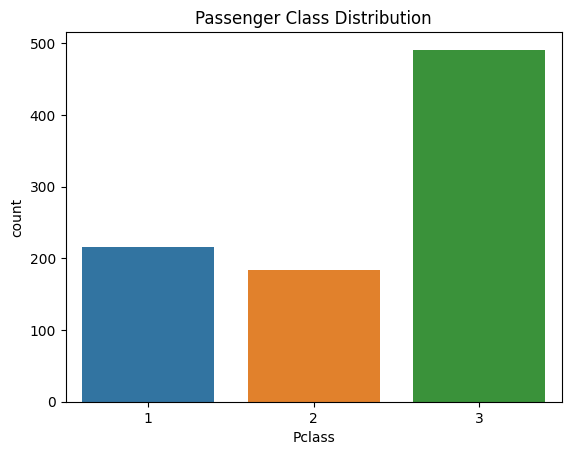

In [ ]:
# Visualize the distribution of passengers by class
sns.countplot(x='Pclass', data=train_df)
plt.title('Passenger Class Distribution')
plt.show()

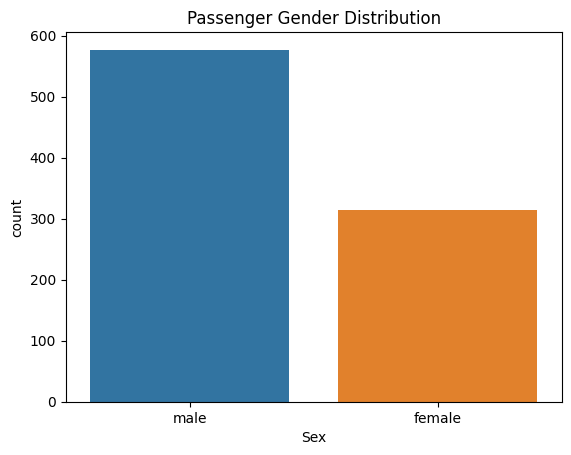

In [ ]:
# Visualize the distribution of passengers by gender
sns.countplot(x='Sex', data=train_df)
plt.title('Passenger Gender Distribution')
plt.show()

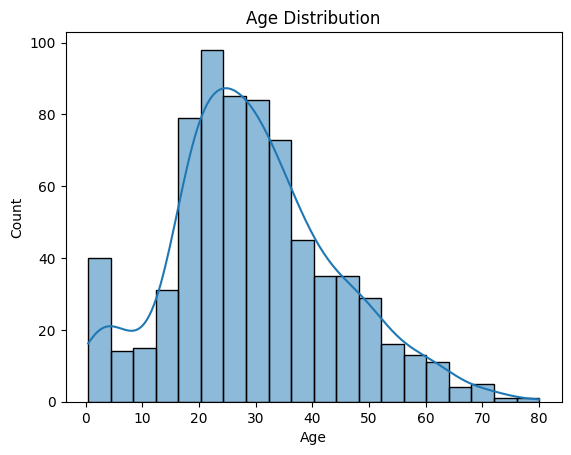

In [ ]:
# Visualize the age distribution of passengers
sns.histplot(train_df['Age'].dropna(), kde=True, bins=20)
plt.title('Age Distribution')
plt.xlabel('Age')
plt.show()

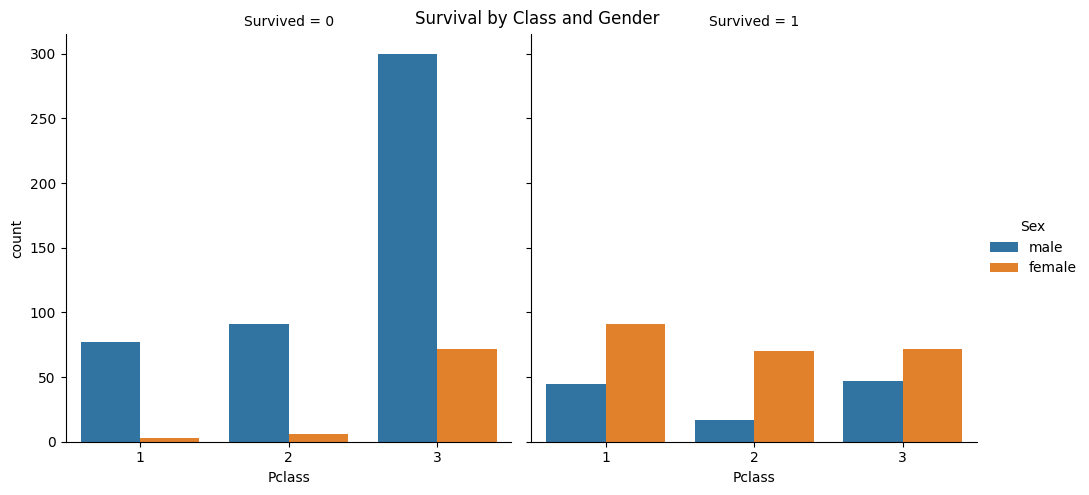

In [ ]:
# Visualize the survival rate by class and gender
sns.catplot(x='Pclass', hue='Sex', col='Survived', kind='count', data=train_df)
plt.suptitle('Survival by Class and Gender')
plt.show()

<ipython-input-18-1cbeba58145d>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(titanic_df.corr(), annot=True, cmap='coolwarm')


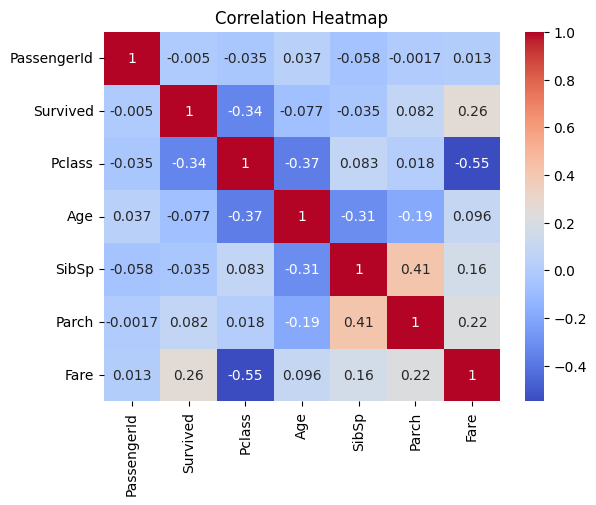

In [ ]:
# Visualize the correlation between numerical variables
sns.heatmap(train_df.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

In [ ]:
# select only the following features and save the new dataset into train_df
# [['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Survived']]
train_df = train_df[['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Survived']]


# drop all nulls
train_df.dropna(inplace=True)

<ipython-input-19-6fbc1b172fcf>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  titanic_df.dropna(inplace=True)


In [ ]:
# check the data types
train_df.dtypes

Pclass        int64
Sex          object
Age         float64
SibSp         int64
Parch         int64
Fare        float64
Survived      int64
dtype: object

In [ ]:
# Convert categorical variables (e.g., 'Sex') to numerical using one-hot encoding
train_df = pd.get_dummies(train_df, columns=['Sex'], drop_first=True)
train_df

,Pclass,Age,SibSp,Parch,Fare,Survived,Sex_male
0,3,22.0,1,0,7.2500,0,1
1,1,38.0,1,0,71.2833,1,0
2,3,26.0,0,0,7.9250,1,0
3,1,35.0,1,0,53.1000,1,0
4,3,35.0,0,0,8.0500,0,1
...,...,...,...,...,...,...,...
885,3,39.0,0,5,29.1250,0,0
886,2,27.0,0,0,13.0000,0,1
887,1,19.0,0,0,30.0000,1,0
889,1,26.0,0,0,30.0000,1,1


In [ ]:
# Split data into features (X) and target (y)
X = train_df.drop('Survived', axis=1)
y = train_df['Survived']

In [ ]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Feature scaling (optional but recommended)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


In [ ]:
# Create an SVM classifier
svm = SVC()

# Fit the SVM model to the training data
svm.fit(X_train, y_train)


SVC()

In [ ]:
# build a function that prints accuracy score, classification report,
# and the confusion matrix
def evaluate_model(y_test, preds):
    """
    create metrics for evaluating each model
    """

    # calculate accuracy score
    acc = accuracy_score(y_test, y_pred_svm)

    # create classification report
    classification_repo = classification_report(y_test, y_pred_svm)

    # confusion matrix
    cm = confusion_matrix(y_test, y_pred_svm)

    # Evaluate the model
    print("Accuracy:", acc)
    print("Classification Report:\n", classification_repo)
    print("Confusion Matrix:\n", cm)


In [ ]:
# Predict on the test data and store it in y_pred_svm
y_pred_svm = svm.predict(X_test)

# evaluate
evaluate_model(y_test, y_pred_svm)

Accuracy: 0.8046511627906977
Classification Report:
               precision    recall  f1-score   support

           0       0.79      0.90      0.84       126
           1       0.83      0.66      0.74        89

    accuracy                           0.80       215
   macro avg       0.81      0.78      0.79       215
weighted avg       0.81      0.80      0.80       215

Confusion Matrix:
 [[114  12]
 [ 30  59]]


In [ ]:
# create a decision tree
decision_tree = DecisionTreeClassifier()

# fit the tree
decision_tree.fit(X_train, y_train)

# store the prediction in y_pred_dt
y_pred_dt = decision_tree.predict(X_test)

In [ ]:
# evaluate the model
evaluate_model(y_test, y_pred_dt)

Accuracy: 0.8046511627906977
Classification Report:
               precision    recall  f1-score   support

           0       0.79      0.90      0.84       126
           1       0.83      0.66      0.74        89

    accuracy                           0.80       215
   macro avg       0.81      0.78      0.79       215
weighted avg       0.81      0.80      0.80       215

Confusion Matrix:
 [[114  12]
 [ 30  59]]


In [ ]:
from sklearn.ensemble import RandomForestClassifier

# build a random forest model
model = RandomForestClassifier(n_estimators=100)

# fit the model
model.fit(X_train, y_train)

# store the predictions inside y_pred_rf
y_pred_rf = model.predict(X_test)

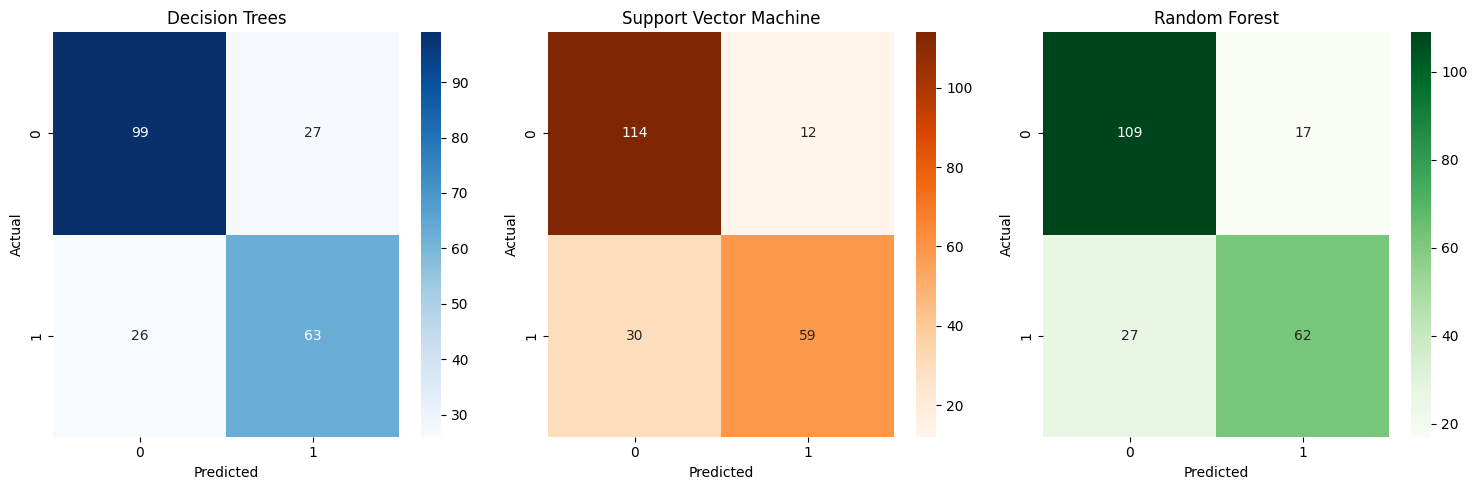

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Create confusion matrices for each model
cm_dt = confusion_matrix(y_test, y_pred_dt)
cm_svm = confusion_matrix(y_test, y_pred_svm)
cm_rf = confusion_matrix(y_test, y_pred_rf)

# Set up subplots for each confusion matrix
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Create a heatmap for Decision Trees
sns.heatmap(cm_dt, annot=True, fmt='d', cmap='Blues', ax=axes[0])
axes[0].set_title('Decision Trees')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')

# Create a heatmap for SVM
sns.heatmap(cm_svm, annot=True, fmt='d', cmap='Oranges', ax=axes[1])
axes[1].set_title('Support Vector Machine')
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('Actual')

# Create a heatmap for Random Forest
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Greens', ax=axes[2])
axes[2].set_title('Random Forest')
axes[2].set_xlabel('Predicted')
axes[2].set_ylabel('Actual')

plt.tight_layout()
plt.show()


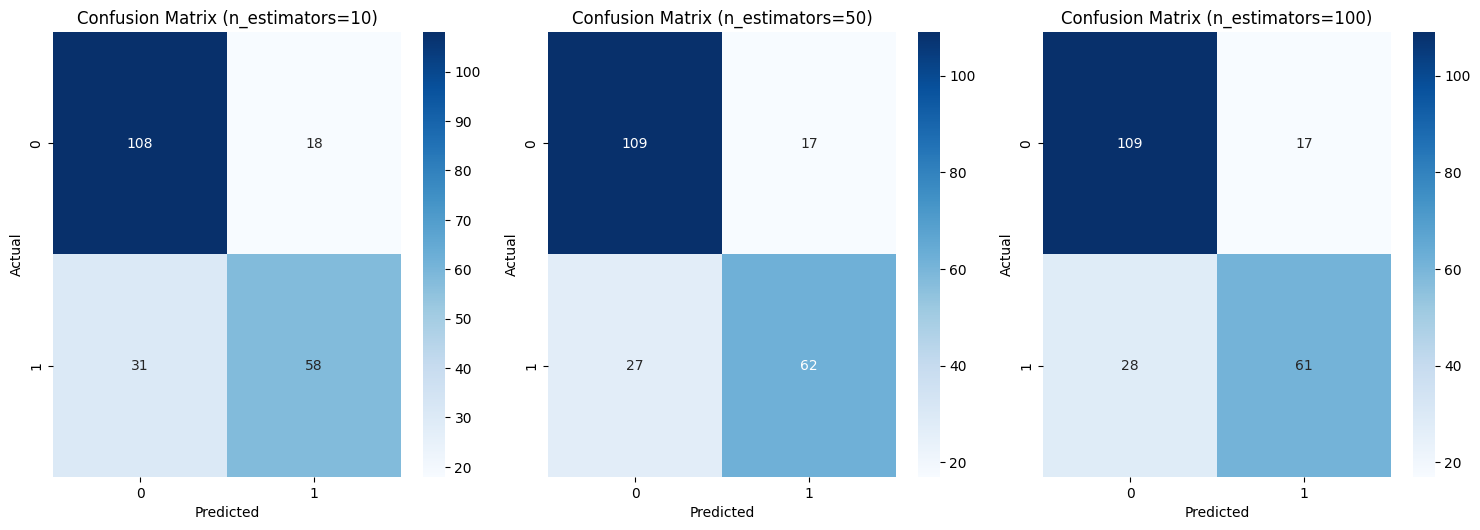

In [ ]:
# try to change the number of trees in random forest and see what happens

# Define a range of values for the number of trees (n_estimators)
n_estimators_values = [10, 50, 100]

# Lists to store confusion matrices for different n_estimators values
confusion_matrices = []

# Loop through different n_estimators values
for n_estimators in n_estimators_values:
    # Create and train the Random Forest model
    rf = RandomForestClassifier(n_estimators=n_estimators)
    rf.fit(X_train, y_train)

    # Make predictions on the test data
    y_pred_rf = rf.predict(X_test)

    # Calculate the confusion matrix and store it in the list
    cm = confusion_matrix(y_test, y_pred_rf)
    confusion_matrices.append(cm)

# Plot the confusion matrices using heatmaps
plt.figure(figsize=(15, 10))
for i, n_estimators in enumerate(n_estimators_values):
    plt.subplot(2, 3, i + 1)
    sns.heatmap(confusion_matrices[i], annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix (n_estimators={n_estimators})')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')

plt.tight_layout()
plt.show()


### Optional - Grid search

Grid Search is a technique used in machine learning to find the best hyperparameters for a machine learning model. It's a systematic method of searching through a range of hyperparameter values to find the combination that results in the best model performance. Grid Search is particularly useful for models with hyperparameters that significantly impact model performance, such as Support Vector Machines (SVMs) with different kernel functions and regularization parameters.

GridSearchCV will try all possible combinations of hyperparameters in the specified parameter grid and choose the combination that results in the best cross-validated performance. This way, you can create an optimized SVC model for your specific dataset.

Keep in mind that Grid Search can be computationally expensive, especially with a large parameter grid. In such cases, you may want to consider other techniques like Randomized Search or Bayesian Optimization to efficiently explore the hyperparameter space.

In [ ]:

# Define a parameter grid for each model
svc_param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf'],
    'gamma': [0.001, 0.01, 0.1]
}

rf_param_grid = {
    'n_estimators': [10, 50, 100],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

dt_param_grid = {
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Create a function to perform grid search and return the best model
def tune_and_evaluate_model(model, param_grid, X_train, y_train, X_test, y_test):
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, n_jobs=-1)
    grid_search.fit(X_train, y_train)
    best_params = grid_search.best_params_
    best_model = grid_search.best_estimator_

    y_pred = best_model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)

    return best_params, best_model, accuracy

# Example usage with your data
svc_best_params, svc_best_model, svc_accuracy = tune_and_evaluate_model(SVC(), svc_param_grid, X_train, y_train, X_test, y_test)
rf_best_params, rf_best_model, rf_accuracy = tune_and_evaluate_model(RandomForestClassifier(), rf_param_grid, X_train, y_train, X_test, y_test)
dt_best_params, dt_best_model, dt_accuracy = tune_and_evaluate_model(DecisionTreeClassifier(), dt_param_grid, X_train, y_train, X_test, y_test)

# Print the results
print("SVC Best Parameters:", svc_best_params)
print("SVC Accuracy:", svc_accuracy)
print("\nRandom Forest Best Parameters:", rf_best_params)
print("Random Forest Accuracy:", rf_accuracy)
print("\nDecision Tree Best Parameters:", dt_best_params)
print("Decision Tree Accuracy:", dt_accuracy)


SVC Best Parameters: {'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}
SVC Accuracy: 0.8

Random Forest Best Parameters: {'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 50}
Random Forest Accuracy: 0.7953488372093023

Decision Tree Best Parameters: {'max_depth': 20, 'min_samples_leaf': 4, 'min_samples_split': 2}
Decision Tree Accuracy: 0.827906976744186


# Your Turn
## Feature Engineering

In [ ]:
# Load original dataset again:
train_df = pd.read_csv(_DATA_PATH/"train.csv", index_col="PassengerId")
test_df = pd.read_csv(_DATA_PATH/"test.csv", index_col="PassengerId")

In [ ]:
# Plot histogram (sns.histplot) of Age with hue set to Pclass, kde=True, and multiple='dodge'
sns.histplot(train_df, x``="Age", kde=True, hue='Pclass', multiple='dodge')

In [ ]:
# Plot pairwise correlation between Pclass and Cabin